In [1]:
import torch
import torchvision
from torchvision import transforms
from PIL import Image
import requests
import time
import numpy as np
import io
from io import BytesIO
import matplotlib.pyplot as plt
%matplotlib inline
import torchvision.models as models
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import os
from torch.utils.data import Dataset
from torch.nn.utils.rnn import pad_sequence
import random
from tqdm import tqdm
import json
from torch.optim.lr_scheduler import CosineAnnealingLR
import threading
import torchvision.models as models
import torch.nn as nn
from pytorch_pretrained_bert import OpenAIGPTTokenizer, OpenAIGPTModel, OpenAIGPTLMHeadModel
from nltk.corpus import wordnet
from caption_transforms import SimCLRData_Caption_Transform
from image_transforms import SimCLRData_image_Transform
from dataset import FlickrDataset
from models import ResNetSimCLR,OpenAI_SIMCLR
from utils import get_gpu_stats,layerwise_trainable_parameters,count_trainable_parameters
from metrics import ContrastiveLoss
from metrics import LARS,Optimizer_simclr
from logger import Logger
from train_fns import train, test
from sklearn.metrics.pairwise import cosine_similarity
from torch.utils.data import random_split
class Flickr30kDataset(torch.utils.data.Dataset):
    def __init__(self, root_dir, token_file_path, transform=None):
        self.root_dir = root_dir
        self.token_file_path = token_file_path
        self.transform = transform
        self.captions = self._load_captions()

    def _load_captions(self):
        with open(self.token_file_path) as tokenfile:
            captions = tokenfile.readlines()
        caption_dict = {}
        for caption in captions:
            caption_parts = caption.strip().split('#')
            image_file_name = caption_parts[0]
            caption_text_parts = caption_parts[1].split('\t')
            caption_number = int(caption_text_parts[0].replace('#',''))
            caption_text = caption_text_parts[1]
            if image_file_name not in caption_dict:
                caption_dict[image_file_name] = []
            caption_dict[image_file_name].append(caption_text)
        return caption_dict

    def __len__(self):
        return len(self.captions)

    def __getitem__(self, idx):
        image_filename = list(self.captions.keys())[idx]
        image_path = os.path.join(self.root_dir, image_filename)
        image = Image.open(image_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        captions = self.captions[image_filename]
        return image, captions
get_gpu_stats()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


cuda
No of GPUs i have is 2
0
My Graphic Card is Tesla V100-PCIE-16GB
Is Cuda Available True


In [150]:
resnet_model = ResNetSimCLR(
    model='resnet50',
    projection_dim=128,
    layers_to_train=['layer3','layer4']
).to(device)

weights_file='/work/08629/pradhakr/maverick2/cv_project/image_caption/image_model_2.pth'
resnet_model.load_state_dict(torch.load(weights_file))
resnet_model.eval()
resnet_model.projection_head=nn.Identity()
gpt_model = OpenAI_SIMCLR(
    model='openai-gpt',
    projection_dim=128,
    layers_to_train=['h.10','h.11']
).to(device)
weights_file='/work/08629/pradhakr/maverick2/cv_project/image_caption/text_model_2.pth'
gpt_model.load_state_dict(torch.load(weights_file))
gpt_model.eval()
gpt_model.projection_head=nn.Identity()
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

ftfy or spacy is not installed using BERT BasicTokenizer instead of SpaCy & ftfy.


In [80]:
dataset = Flickr30kDataset('/work/08629/pradhakr/maverick2/cv_project/flickr30k-images', 
                           '/work/08629/pradhakr/maverick2/cv_project/flickr30k_captions/results_20130124.token',
                          transform=preprocess)

# Split the dataset into train, validation, and test sets
train_set, val_set, test_set = torch.utils.data.random_split(dataset, [29783, 1000, 1000])
val_loader = DataLoader(val_set, 
                         batch_size=128, 
                         shuffle=False, 
                         num_workers=4, 
                         pin_memory=True)

In [42]:
image_features = {}
text_features = {}
for i in tqdm(range(len(val_set))):
    image, captions = val_set[i]
    image_tensor = image.unsqueeze(0)
    text_features[i] = []
    with torch.no_grad():
        image_features_, _ = resnet_model(image_tensor, device)
        for caption in captions:
            caption_features, _ = gpt_model(caption, device)
            text_features[i].append(caption_features.cpu().numpy().flatten())
    image_features[i] = image_features_.cpu().numpy().flatten()


100%|██████████| 1000/1000 [01:34<00:00, 10.54it/s]


In [144]:
image_features_list = []
text_features = []
caption_number=1
for i, batch in tqdm(enumerate(val_loader)):
    images, captions = batch
    batch_size = images.shape[0]
    with torch.no_grad():
        image_features_, _ = resnet_model(images,device)
        caption_features, _ = gpt_model(captions[caption_number], device)
        text_features.append(caption_features.cpu().numpy())
        image_features_list.append(image_features_.cpu().numpy())

8it [00:05,  1.52it/s]


In [149]:
text_features

[array([[ 0.71495366,  0.31635642, -0.05411261, ...,  0.81628686,
          0.22131294,  0.5748524 ],
        [ 0.6824536 ,  0.38810483, -0.07543551, ...,  0.01129525,
          0.43389925,  0.30968192],
        [ 0.7542154 ,  0.08634444, -0.31551597, ...,  0.78046197,
          0.19189107,  0.1489408 ],
        ...,
        [ 1.2238927 ,  0.07063252, -0.41676453, ...,  0.18386415,
         -0.19723536, -0.332601  ],
        [ 0.30846226,  0.25689077, -0.01948044, ...,  0.22817916,
          0.07142132,  0.18224643],
        [ 0.81149584,  0.04714438, -0.23803082, ...,  0.2279782 ,
          0.24363077,  0.04954271]], dtype=float32),
 array([[ 0.77609533,  0.65112126,  0.12457166, ...,  0.13365248,
          0.5044584 , -0.24440502],
        [ 0.63276625,  0.28594247,  0.09721221, ...,  0.5710953 ,
          0.02625167,  0.14443858],
        [ 0.5140667 , -0.07975448, -0.5261504 , ...,  0.20584577,
         -0.02045589,  0.04402165],
        ...,
        [ 0.12121399,  0.03382296,  0.3

In [128]:
image_features[0]

array([0.23492669, 0.5458666 , 0.08507551, ..., 0.06817852, 0.09410006,
       0.01446531], dtype=float32)

In [62]:
similarity = (np.dot(query_text_features[0], image_features[0]) / (np.linalg.norm(query_text_features[0]) * 
                                                                   np.linalg.norm(image_features[0])))
similarity

ValueError: shapes (53760,) and (2048,) not aligned: 53760 (dim 0) != 2048 (dim 0)

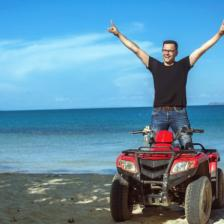

In [168]:
query_image_path ='/home1/08629/pradhakr/cv_project/data/test/52720721895_0c08d87c31.jpg'
image = Image.open(query_image_path)
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
image

In [169]:
query_image = preprocess(image).unsqueeze(0)
with torch.no_grad():
    features,features = resnet_model(query_image,device)

In [170]:
query_features = features.cpu().squeeze().numpy()
query_features.shape

(2048,)

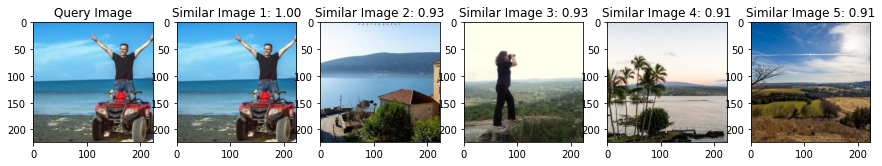

In [171]:
similarities = []
image_paths = []
for root, dirs, files in os.walk('/home1/08629/pradhakr/cv_project/data/test'):
    for file in files:
        if file.endswith('.jpg'):
            image_path = os.path.join(root, file)
            image = Image.open(image_path)
            image_tensor = preprocess(image).unsqueeze(0)
            with torch.no_grad():
                image_features,_ = resnet_model(image_tensor,device)
                image_features = image_features.cpu().squeeze().numpy()
            similarity = (np.dot(query_features, image_features) / (np.linalg.norm(query_features) * 
                                                                   np.linalg.norm(image_features)))
            similarities.append(similarity)
            image_paths.append(image_path)
k = 5
indices = np.argsort(similarities)[::-1][:k]
similar_images = [image_paths[i] for i in indices]
query_image = Image.open(query_image_path)
fig, axs = plt.subplots(1, k+1, figsize=(15, 15))
axs[0].imshow(query_image)
axs[0].set_title('Query Image')
for i, image_path in enumerate(similar_images):
    image = Image.open(image_path)
    similarity_score = similarities[indices[i]]
    axs[i+1].imshow(image)
    axs[i+1].set_title('Similar Image {}: {:.2f}'.format(i+1, similarity_score))

plt.show()

In [72]:
similarities

[0.29136422,
 0.30486035,
 -0.070383035,
 0.33898437,
 0.47228062,
 0.2966788,
 0.87035847,
 0.22393546,
 0.26769277,
 0.17285481,
 0.3069114,
 0.44888353,
 0.6606292,
 0.097614706,
 0.0091306325,
 0.5552008,
 0.727334,
 0.41181216,
 0.036841065,
 0.17107639,
 0.33743882,
 0.07792943,
 0.6433817,
 -0.031705603,
 0.19597779,
 0.21367994,
 0.61528516,
 -0.039494567,
 0.31905848,
 -0.040240023,
 0.28633112,
 0.5445659,
 0.5416516,
 0.32179582,
 0.3396094,
 0.6596464,
 0.3426614,
 0.1859482,
 0.3425077,
 0.24628252,
 0.19634539,
 0.41517636,
 0.0807948,
 0.16834532,
 0.14932467,
 0.38447383,
 0.41140196,
 0.548456,
 0.4500859,
 0.7660987,
 0.3082248,
 0.49281582,
 0.5852946,
 0.70506084,
 0.497641,
 0.55537754,
 0.39807573,
 0.382084,
 0.4745599,
 0.13963322,
 0.4786334,
 0.64598376,
 0.18535413,
 0.4640355,
 0.25296256,
 0.41042233,
 0.2706909,
 0.20055804,
 0.38932097,
 0.28990886,
 0.5783692,
 0.1800418,
 0.36404115,
 0.20658784,
 0.24068938,
 0.5301348,
 0.24409643,
 0.1511635,
 0.6466